# 1. 在线记录功能之本地云盘创建

## 1.1 添加在云盘创建文件的功能

In [7]:
import os

def create_directory(directory):
    """
    根据项目创建云盘目录
    """
    base_path = "/root/autodl-tmp/iquery项目/iquery云盘"
    full_path = os.path.join(base_path, directory)
    # 如果目录不存在，则创建它
    if not os.path.exists(full_path):
        os.makedirs(full_path)
        print(f"目录 {directory} 创建成功")
    else:
        print(f"目录 {directory} 已存在")


In [170]:
directory = "my_directory"
create_directory(directory)

目录 my_directory 创建成功


In [8]:
import os
from docx import Document

def append_in_doc(folder_name, doc_name, qa_string):
    """"
    往文件里追加内容
    @param folder_name=目录名，doc_name=文件名，qa_string=追加的内容
    """
    base_path = "/root/autodl-tmp/iquery项目/iquery云盘"
    ## 目录地址
    full_path_folder=base_path+"/"+folder_name
    ## 文件地址
    full_path_doc = os.path.join(full_path_folder, doc_name)+".doc"
    

    # 检查目录是否存在，如果不存在则创建
    if not os.path.exists(full_path_folder):
        os.makedirs(full_path_folder)
    
    # 检查文件是否存在
    if os.path.exists(full_path_doc):
        # 文件存在，打开并追加内容
        document = Document(full_path_doc)
    else:
        # 文件不存在，创建一个新的文档对象
        document = Document()
    # 追加内容
    document.add_paragraph(qa_string)
    # 保存文档
    document.save(full_path_doc)
    print(f"内容已追加到 {doc_name}")

In [172]:
# 示例用法
append_in_doc('my_directory', 'example_doc', '天青色等烟雨，而我在等你')

内容已追加到 example_doc


## 1.2 之前的功能中融入文档记录的功能

In [168]:
import openai
import os
import numpy as np
import pandas as pd
import json
import io
from openai import OpenAI
import inspect
import pymysql


openai.api_key = os.getenv("OPENAI_API_KEY")

client = OpenAI(api_key=openai.api_key)

In [10]:
def auto_functions(functions_list):
    """
    Chat模型的functions参数编写函数
    :param functions_list: 包含一个或者多个函数对象的列表；
    :return：满足Chat模型functions参数要求的functions对象
    """
    def functions_generate(functions_list):
        # 创建空列表，用于保存每个函数的描述字典
        functions = []
        # 对每个外部函数进行循环
        for function in functions_list:
            # 读取函数对象的函数说明
            function_description = inspect.getdoc(function)
            # 读取函数的函数名字符串
            function_name = function.__name__

            system_prompt = '以下是某的函数说明：%s' % function_description
            user_prompt = '根据这个函数的函数说明，请帮我创建一个JSON格式的字典，这个字典有如下5点要求：\
                           1.字典总共有三个键值对；\
                           2.第一个键值对的Key是字符串name，value是该函数的名字：%s，也是字符串；\
                           3.第二个键值对的Key是字符串description，value是该函数的函数的功能说明，也是字符串；\
                           4.第三个键值对的Key是字符串parameters，value是一个JSON Schema对象，用于说明该函数的参数输入规范。\
                           5.输出结果必须是一个JSON格式的字典，只输出这个字典即可，前后不需要任何前后修饰或说明的语句' % function_name

            response = client.chat.completions.create(
                              model="gpt-3.5-turbo",
                              messages=[
                                {"role": "system", "content": system_prompt},
                                {"role": "user", "content": user_prompt}
                              ]
                            )
            json_function_description=json.loads(response.choices[0].message.content.replace("```","").replace("json",""))
            json_str={"type": "function","function":json_function_description}
            functions.append(json_str)
        return functions
    
    max_attempts = 4
    attempts = 0

    while attempts < max_attempts:
        try:
            functions = functions_generate(functions_list)
            break  # 如果代码成功执行，跳出循环
        except Exception as e:
            attempts += 1  # 增加尝试次数
            print("发生错误：", e)
            if attempts == max_attempts:
                print("已达到最大尝试次数，程序终止。")
                raise  # 重新引发最后一个异常
            else:
                print("正在重新运行...")
    return functions

In [11]:
def run_conversation(messages, functions_list=None, model="gpt-3.5-turbo"):
    """
    能够自动执行外部函数调用的对话模型
    :param messages: 必要参数，字典类型，输入到Chat模型的messages参数对象
    :param functions_list: 可选参数，默认为None，可以设置为包含全部外部函数的列表对象
    :param model: Chat模型，可选参数，默认模型为gpt-3.5-turbo
    :return：Chat模型输出结果
    """
    # 如果没有外部函数库，则执行普通的对话任务
    if functions_list == None:
        response = client.chat.completions.create(
                        model=model,
                        messages=messages,
                        )
        response_message = response.choices[0].message
        final_response = response_message.content
        
    # 若存在外部函数库，则需要灵活选取外部函数并进行回答
    else:
        # 创建functions对象
        tools = auto_functions(functions_list)
        #tools = [{'type': 'function', 'function': {'name': 'sunwukong_function', 'description': '定义了数据集计算过程', 'parameters': {'type': 'object', 'properties': {'data': {'type': 'string', 'description': '表示带入计算的数据表，用字符串进行表示'}}, 'required': ['data']}}}, {'type': 'function', 'function': {'name': 'tangseng_function', 'description': '该函数定义了数据集计算过程', 'parameters': {'type': 'object', 'properties': {'data': {'type': 'string', 'description': '必要参数，表示带入计算的数据表，用字符串进行表示'}}, 'required': ['data']}}}]
    

        # 创建外部函数库字典
        available_functions = {func.__name__: func for func in functions_list}

        # 第一次调用大模型
        response = client.chat.completions.create(
                        model=model,
                        messages=messages,
                        tools=tools,
                        tool_choice="auto", )
        response_message = response.choices[0].message

        tool_calls = response_message.tool_calls
        if tool_calls:
            messages.append(response_message) 
            for tool_call in tool_calls:
                function_name = tool_call.function.name
                function_to_call = available_functions[function_name]
                function_args = json.loads(tool_call.function.arguments)
                function_response = function_to_call(**function_args)
                messages.append(
                    {
                        "tool_call_id": tool_call.id,
                        "role": "tool",
                        "name": function_name,
                        "content": function_response,
                    }
                ) 
            print(messages)
            ## 第二次调用模型
            second_response = client.chat.completions.create(
                model=model,
                messages=messages,
            ) 
            # 获取最终结果
            final_response = second_response.choices[0].message.content
        else:
            final_response = response_message.content
                
    return final_response

In [12]:
# 打开并读取Markdown文件
with open('/root/autodl-tmp/iquery项目/data/数据字典/iquery数据字典.md', 'r', encoding='utf-8') as f:
    md_content = f.read()
    
md_content

'# iquery数据字典：iquery数据库数据字典\n\n本数据字典记录了iquery数据库中各张数据表的基本情况。\n\n## 1.user_demographics数据表\n\n- 基本解释\n\n  \u200b\t\tuser_demographics数据表记录了电信用户的个人基本情况，主要涵盖客户基本生物属性，包括性别、年龄状况、是否结婚以及是否经济独立等。\n\n- 数据来源\n\n  \u200b\tuser_demographics数据集由一线业务人员人工采集记录，并且通过回访确认相关信息，数据集的准确性和可信度都非常高。\n\n- 各字段说明\n\n| Column Name | Description | Value Range | Value Explanation | Type |\n|-------------|-------------|-------------|-------------------|------|\n| customerID | 客户ID，user_demographics数据表主键 |              | 由数字和字母组成的 | VARCHAR(255) |\n| gender | 用户的性别 | Female, Male | Female (女性), Male (男性) | VARCHAR(255) |\n| SeniorCitizen | 是否为老人 | 0, 1 | 0 (不是), 1 (是) | INT |\n| Partner | 用户是否有伴侣 | Yes, No | Yes (有), No (没有) | VARCHAR(255) |\n| Dependents | 用户经济是否独立，往往用于判断用户是否已经成年 | No, Yes | Yes (有), No (没有) | VARCHAR(255) |\n\n## 2.user_services数据表\n\n- 基本解释\n\n  \u200b        user_services数据表记录了每位用户订购电信服务的基本情况，截至目前，电信服务商提供了种类多样的服务，包括电话类服务和网络类服务等，本数据集表记录了每位用户订阅电信服务的基本情况。\n\n- 数据来源\n\n  \u200b\t\tuser_services数据表由后台系统

In [13]:
def sql_inter(sql_query):
    """
    用于获取iquery数据库中各张表的有关相关信息，\
    核心功能是将输入的SQL代码传输至iquery数据库所在的MySQL环境中进行运行，\
    并最终返回SQL代码运行结果。需要注意的是，本函数是借助pymysql来连接MySQL数据库。
    :param sql_query: 字符串形式的SQL查询语句，用于执行对MySQL中iquery数据库中各张表进行查询，并获得各表中的各类相关信息
    :return：sql_query在MySQL中的运行结果。
    """
    
    mysql_pw = "iquery_agent"
    
    connection = pymysql.connect(
            host='localhost',  # 数据库地址
            user='iquery_agent',  # 数据库用户名
            passwd=mysql_pw,  # 数据库密码
            db='iquery',  # 数据库名
            charset='utf8'  # 字符集选择utf8
        )
    
    try:
        with connection.cursor() as cursor:
            # SQL查询语句
            sql = sql_query
            cursor.execute(sql)

            # 获取查询结果
            results = cursor.fetchall()

    finally:
        connection.close()
    
    
    return json.dumps(results)

In [19]:
functions_list = [sql_inter]

In [14]:
import ast

def extract_sql(str):
    # 使用literal_eval将字符串转换为字典
    dict_data = ast.literal_eval(json.dumps(str))

    # 提取'sql_query'的值
    sql_query_value = dict_data['sql_query']+""
    # 提取并返回'sql_query'的值
    return sql_query_value

In [90]:
# import ast

# def extract_sql(str):
#     # 使用literal_eval将字符串转换为字典
#     dict_data = json.loads(str)

#     # 提取'sql_query'的值
#     sql_query_value = dict_data['sql_query']
#     # 提取并返回'sql_query'的值
#     return sql_query_value

In [15]:
def check_code_run(messages, functions_list=None, model="gpt-3.5-turbo",auto_run = True):
    """
    能够自动执行外部函数调用的对话模型
    :param messages: 必要参数，字典类型，输入到Chat模型的messages参数对象
    :param functions_list: 可选参数，默认为None，可以设置为包含全部外部函数的列表对象
    :param model: Chat模型，可选参数，默认模型为gpt-3.5-turbo
    :return：Chat模型输出结果
    """
    # 如果没有外部函数库，则执行普通的对话任务
    if functions_list == None:
        response = client.chat.completions.create(
                        model=model,
                        messages=messages,
                        )
        response_message = response.choices[0].message
        final_response = response_message.content
        
    # 若存在外部函数库，则需要灵活选取外部函数并进行回答
    else:
        # 创建functions对象
        tools = auto_functions(functions_list)
        

        # 创建外部函数库字典
        available_functions = {func.__name__: func for func in functions_list}

        # 第一次调用大模型
        response = client.chat.completions.create(
                        model=model,
                        messages=messages,
                        tools=tools,
                        tool_choice="auto", )
        response_message = response.choices[0].message
        tool_calls = response_message.tool_calls
        if tool_calls:
            messages.append(response_message) 
            for tool_call in tool_calls:
                function_name = tool_call.function.name
                function_to_call = available_functions[function_name]
                function_args = json.loads(tool_call.function.arguments)
              
                if auto_run == False:
                    print("SQL字符串的数据类型")
                    print(type(function_args))
                    sql_query = extract_sql(function_args)
                
                    res = input('即将执行以下代码：%s。是否确认并继续执行（1），或者退出本次运行过程（2）' % sql_query)
                    if res == '2':
                        print("终止运行")
                        return None
                    else:
                        print("正在执行代码，请稍后...")
                        
                function_response = function_to_call(**function_args)
                messages.append(
                    {
                        "tool_call_id": tool_call.id,
                        "role": "tool",
                        "name": function_name,
                        "content": function_response,
                    }
                ) 
            ## 第二次调用模型
            second_response = client.chat.completions.create(
                model=model,
                messages=messages,
            ) 
            # 获取最终结果
            final_response = second_response.choices[0].message.content
        else:
            final_response = response_message.content
    del messages
                
    return final_response

In [16]:
import tiktoken

def chat_with_inter(functions_list=None, 
                    prompt="你好呀", 
                    model="gpt-3.5-turbo", 
                    system_message=[{"role": "system", "content": "你是一个智能助手。"}], 
                    auto_run = True):
    
    print("正在初始化外部函数库")
    # 创建函数列表对应的参数解释列表
    functions = auto_functions(functions_list)
    print("外部函数库初始化完成")
    project_name = input("请输入当前分析项目名称：")
    folder_name = create_directory(project_name)
    print("已完成数据分析文件创建")
    doc_name = input("请输入当前分析需求，如数据清理，数据处理，数据分析段等：")
    doc_name += '问答'
    print("好的，即将进入交互式分析流程")
    # 多轮对话阈值
  # 多轮对话阈值
    if 'gpt-4' in model:
        tokens_thr = 6000
    elif '16k' in model:
        tokens_thr = 14000
    else:
        tokens_thr = 3000
    
    messages = system_message
    ## 完成给用户输入的问题赋值
    user_input = prompt
    messages.append({"role": "user", "content": prompt})
    ## 计算token大小
    embedding_model = "text-embedding-ada-002"
    # 模型对应的分词器（TOKENIZER）
    embedding_encoding = "cl100k_base"
    encoding = tiktoken.get_encoding(embedding_encoding)
    tokens_count = len(encoding.encode((prompt + system_message[0]["content"])))
    
    while True:           
        answer = check_code_run(messages, 
                                functions_list=functions_list, 
                                model=model, 
                                auto_run = auto_run)
        
        
        print(f"模型回答: {answer}")
        
        #####################判断是否记录文档 start#######################
        while True:
            record = input('是否记录本次回答（1），还是再次输入问题并生成该问题答案（2）')
            if record == '1':
                
                Q_temp = 'Q:' + user_input
                A_temp = 'A:' + answer
                
                append_in_doc(folder_name=project_name, 
                                               doc_name=doc_name, 
                                               qa_string=Q_temp)
                append_in_doc(folder_name=project_name, 
                                               doc_name=doc_name, 
                                               qa_string=A_temp)
                
                # 记录本轮问题答案
                messages.append({"role": "assistant", "content": answer})
                break
            else:
                print('好的，请再次输入问题')
                user_input = input()
                messages[-1]["content"] = user_input
                answer = check_code_run(messages, 
                                        functions_list=functions_list,                                      
                                        model=model,                                       
                                        auto_run = auto_run)  
                
                print(f"模型回答: {answer}")
                
        ########################判断是否记录文档 stop #######################
        

        # 询问用户是否还有其他问题
        user_input = input("您还有其他问题吗？(输入退出以结束对话): ")
        if user_input == "退出":
            del messages
            break

        # 记录新一轮问答
        messages.append({"role": "assistant", "content": answer})
        messages.append({"role": "user", "content": user_input})
        
        # 计算当前总token数
        tokens_count += len(encoding.encode((answer + user_input)))
        
        # 删除超出token阈值的对话内容
        while tokens_count >= tokens_thr:
            tokens_count -= len(encoding.encode(messages.pop(1)["content"]))

In [20]:
functions_list

[<function __main__.sql_inter(sql_query)>]

In [22]:
chat_with_inter(functions_list=functions_list, 
                prompt="介绍一下iquery数据库中的表的情况", 
                model="gpt-3.5-turbo-16k", 
                system_message=[{"role": "system", "content": md_content}], 
                auto_run = False)

正在初始化外部函数库
外部函数库初始化完成


请输入当前分析项目名称： 数据分析测试


目录 数据分析测试 创建成功
已完成数据分析文件创建


请输入当前分析需求，如数据清理，数据处理，数据分析段等： 数据分析


好的，即将进入交互式分析流程
SQL字符串的数据类型
<class 'dict'>


即将执行以下代码：SHOW TABLES。是否确认并继续执行（1），或者退出本次运行过程（2） 1


正在执行代码，请稍后...
模型回答: 在iquery数据库中，共有8张表：

1. user_churn: 记录了当前用户的流失情况。
2. user_churn_new: 该表是user_churn表的一个备份表。
3. user_demographics: 记录了电信用户的个人基本情况，包括性别、年龄等属性信息。
4. user_demographics_new: 该表是user_demographics表的一个备份表。
5. user_payments: 记录了每位用户的支付情况，包括合同类型、支付方式、月费用等信息。
6. user_payments_new: 该表是user_payments表的一个备份表。
7. user_services: 记录了每位用户订阅的电信服务情况，包括电话服务、互联网服务等信息。
8. user_services_new: 该表是user_services表的一个备份表。

以上是该数据库中的所有表。


是否记录本次回答（1），还是再次输入问题并生成该问题答案（2） 1


内容已追加到 数据分析问答
内容已追加到 数据分析问答


您还有其他问题吗？(输入退出以结束对话):  退出


# 2. 数据分析报告撰写初探

## 2.1 学习本公司的数据分析业务知识

In [23]:
# 读取业务知识文档
with open('/root/autodl-tmp/iquery项目/data/业务知识/本公司数据分析师业务介绍.md', 'r', encoding='utf-8') as f:
    da_instruct = f.read()

In [191]:
from IPython.display import display, Markdown, Code

display(Markdown(da_instruct))

1.你是一名资深数据分析师，擅长挖掘数字规律并进行深度分析，并擅长编写数据分析报告。

2.目前你正在参与一个名为电信用户行为分析的数据分析项目当中，这个项目的核心目的是分析当前电信用户相关数据，并对用户流失情况进行分析。

3.电信用户流失项目允许使用存储在MySQL中的一个名为iquery的数据集，该数据集中包含了全部和电信用户流失相关的数据集。

4.你目前的核心职责是编写数据分析报告，你能够获得一系列技术人员探索得到的基本结论，也就是一系列前期问答文本，需要在此基础之上编写完善、权威、且容易阅读的数据分析报告。

5.你编写的数据分析报告需要分模块进行编写，一篇完整的数据分析报告必须包括以下四个内容模块，分别为数据探索、数据质量校验、数据清洗、数据分析，以下分别解释每个内容模块必须包含的内容：

- **问题定义**：明确要回答的问题或达到的目标。
- **数据获取**：找到并收集需要的数据。数据可以来自多种来源，比如数据库，网络，第三方API等。
- **数据清洗和预处理**：去除无用、重复、错误的数据，处理缺失值，可能还需要进行数据类型转换、数据归一化等操作。
- **数据探索和理解**：通过统计分析，可视化等方式对数据进行深入理解，找到数据的规律和特点。
- **数据建模**：选择合适的算法和模型，如回归分析，决策树，神经网络等，对数据进行建模。
- **模型训练和评估**：使用训练数据集对模型进行训练，并用测试数据集进行模型评估，如准确率，召回率，F1值等。
- **结果解释和报告**：将分析和模型结果进行整理和解释，形成报告，为决策提供支持。
- **模型部署和监控**：将模型部署到实际业务中，并进行持续的监控和优化。

In [24]:
## 实现根据项目和文件获取文件内容的方法

from docx import Document
import os

def get_file_content(project_name, file_name):
    """
    实现根据项目名和文件名获取文件内容的方法
    @param project_name:项目名，file_name：文件名
    @return 文件内容
    """
    # 构建文件的完整路径
    base_path = "/root/autodl-tmp/iquery项目/iquery云盘"
    file_path = os.path.join(project_name, file_name)
    full_path = os.path.join(base_path, file_path)+".doc"
    print("打印文件路径："+full_path)
    
    # 确保文件存在
    if not os.path.exists(full_path):
        return "文件不存在"
    
    try:
        # 加载文档
        doc = Document(full_path)
        content = []
        
        # 遍历文档中的每个段落，并收集文本
        for para in doc.paragraphs:
            content.append(para.text)
        
        # 将所有段落文本合并成一个字符串返回
        return '\n'.join(content)
    except Exception as e:
        return f"读取文件时发生错误: {e}"


In [193]:
file_content = get_file_content('电信用户行为分析', '数据分析问答')

打印文件路径：/root/autodl-tmp/iquery项目/iquery云盘/电信用户行为分析/数据分析问答.doc


In [194]:
display(Markdown(file_content))

Q:介绍一下iquery数据库中的表的情况
A:iquery数据库中共有8张数据表，它们分别是：

1. user_churn: 记录了当前用户的流失情况。
2. user_churn_new: 一个新的用户流失数据表，可能包含了一些更新的数据。
3. user_demographics: 记录了电信用户的个人基本情况，包括性别、年龄状况、是否结婚以及是否经济独立等。
4. user_demographics_new: 一个新的用户个人基本情况数据表，可能包含了一些更新的数据。
5. user_payments: 记录了每一位用户的支付情况，包括支付方式、合同类型和具体支付金额等。
6. user_payments_new: 一个新的用户支付情况数据表，可能包含了一些更新的数据。
7. user_services: 记录了每位用户订购电信服务的情况，包括电话服务、互联网服务和网络电视等。
8. user_services_new: 一个新的用户订购电信服务的情况数据表，可能包含了一些更新的数据。

以上是iquery数据库中的数据表情况。
Q:user_demographics表里面男性和女性的人数占比分别是多少？
A:在user_demographics数据表中，男性的人数为2744人，女性的人数为2609人。所以男性人数占比约为51.24%，女性人数占比约为48.76%。
Q:看一下这个表user_payments里面有哪些字段？
A:user_payments表中的字段如下：

1. customerID: 客户ID，主键列，类型为varchar(255)
2. Contract: 合同类型，类型为varchar(255)
3. PaperlessBilling: 是否无纸化账单，类型为varchar(255)
4. PaymentMethod: 支付方式，类型为varchar(255)
5. MonthlyCharges: 月费用，类型为float
6. TotalCharges: 总费用，类型为varchar(255)

以上是user_payments表中的字段信息。

In [195]:
# 读取数据字典
with open('/root/autodl-tmp/iquery项目/data/数据字典/iquery数据字典.md', 'r', encoding='utf-8') as f:
    md_content = f.read()

In [196]:
# 读取问答结果
file_content = get_file_content('电信用户行为分析', '数据分析问答')

打印文件路径：/root/autodl-tmp/iquery项目/iquery云盘/电信用户行为分析/数据分析问答.doc


In [197]:
# 读取业务知识文档
with open('/root/autodl-tmp/iquery项目/data/业务知识/本公司数据分析师业务介绍.md', 'r', encoding='utf-8') as f:
    da_instruct = f.read()

In [198]:
messages=[
            {"role": "system", "content": da_instruct}, 
            {"role": "system", "content": 'iquery数据库数据字典:%s' % md_content}, 
            {"role": "system", "content": '数据探索和理解阶段问答文本:%s' % file_content}, 
            {"role": "user", "content": "请帮我编写电信用户行为分析的分析报告中的数据探索和理解部分内容"}
        ]

response = client.chat.completions.create(
        model="gpt-3.5-turbo-16k",
        messages=messages,
    )

display(Markdown(response.choices[0].message.content))

## 数据探索和理解

在电信用户行为分析项目中，数据探索和理解是非常重要的一步。通过对数据的深入分析，我们可以找到数据的规律和特点，为后续的数据清洗和分析提供指导和依据。

本部分将对iquery数据库中的数据进行探索和分析，重点关注用户个人基本情况、订购电信服务情况以及支付情况等方面。下面是具体的数据探索和理解分析结果：

### 用户个人基本情况分析：

**性别分布分析：**

根据user_demographics数据表，我们可以看到数据库中共有5353个客户的个人基本信息。其中，男性用户的数量为2744人，女性用户的数量为2609人。通过计算，我们可以得出男性用户占比为51.24%，女性用户占比为48.76%。

### 订购电信服务情况分析：

**电话服务情况分析：**

根据user_services数据表，用户中开通电话服务的人数为6361人，占总用户数的63.72%；没有开通电话服务的人数为3498人，占总用户数的34.99%；有部分用户没有记录电话服务情况。

**互联网服务情况分析：**

根据user_services数据表，用户中开通互联网服务的人数为5517人，占总用户数的55.28%；没有开通互联网服务的人数为3361人，占总用户数的33.68%；有部分用户没有记录互联网服务情况。

**网络电视服务情况分析：**

根据user_services数据表，用户中开通网络电视服务的人数为3780人，占总用户数的37.86%；没有开通网络电视服务的人数为2812人，占总用户数的28.15%；有部分用户没有记录网络电视服务情况。

### 支付情况分析：

**合同类型分析：**

根据user_payments数据表，用户中选择月付合同的人数为3875人，占总用户数的38.81%；选择一年付合同的人数为1473人，占总用户数的14.74%；选择两年付合同的人数为1695人，占总用户数的16.97%。

**纸质账单使用情况分析：**

根据user_payments数据表，选择无纸化账单的人数为3366人，占总用户数的33.70%；选择纸质账单的人数为2770人，占总用户数的27.73%。

**支付方式分析：**

根据user_payments数据表，用户中选择电子支票作为支付方式的人数为2365人，占总用户数的23.67%；选择邮寄支票的人数为1522人，占总用户数的15.24%；选择银行转账的人数为1543人，占总用户数的15.43%；选择信用卡支付的人数为2264人，占总用户数的22.64%。

通过以上数据的探索和分析，我们对电信用户的个人基本情况、订购电信服务情况和支付情况等有了初步的了解。下一步，我们将进行数据质量校验，并进行数据清洗和预处理。

# 3. 实现本地Python代码解释器

In [25]:
def extract_data(sql_query,df_name):
    """
    用于借助pymysql，将MySQL中的iquery数据库中的表读取并保存到本地Python环境中。
    :param sql_query: 字符串形式的SQL查询语句，用于提取MySQL中iquery数据库中的某张表。
    :param df_name: 将MySQL数据库中提取的表格进行本地保存时的变量名，以字符串形式表示。
    :return：表格读取和保存结果
    """
    
    mysql_pw = "iquery_agent"
    
    connection = pymysql.connect(
            host='localhost',  # 数据库地址
            user='iquery_agent',  # 数据库用户名
            passwd=mysql_pw,  # 数据库密码
            db='iquery',  # 数据库名
            charset='utf8'  # 字符集选择utf8
        )
    
    
    globals()[df_name] = pd.read_sql(sql_query, connection)
    
    return "已成功完成%s变量创建" % df_name

In [26]:
sql_query = "SELECT * FROM user_demographics LIMIT 10"

In [27]:
data_name = "test_dataframe"
extract_data(sql_query,data_name)

/tmp/ipykernel_150812/966933623.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  globals()[df_name] = pd.read_sql(sql_query, connection)


'已成功完成test_dataframe变量创建'

In [28]:
test_dataframe

,customerID,gender,SeniorCitizen,Partner,Dependents
0,0003-MKNFE,Male,0,No,No
1,0004-TLHLJ,Male,0,No,No
2,0011-IGKFF,Male,1,Yes,No
3,0013-EXCHZ,Female,1,Yes,No
4,0013-SMEOE,Female,1,Yes,No
5,0015-UOCOJ,Female,1,No,No
6,0017-DINOC,Male,0,No,No
7,0017-IUDMW,Female,0,Yes,Yes
8,0019-EFAEP,Female,0,No,No
9,0019-GFNTW,Female,0,No,No


In [237]:
functions_list = [extract_data]

In [239]:
tools = auto_functions(functions_list)
tools

[{'type': 'function',
  'function': {'name': 'extract_data',
   'description': '用于借助pymysql，将MySQL中的iquery数据库中的表读取并保存到本地Python环境中。',
   'parameters': {'type': 'object',
    'properties': {'sql_query': {'type': 'string',
      'description': '字符串形式的SQL查询语句，用于提取MySQL中iquery数据库中的某张表。'},
     'df_name': {'type': 'string',
      'description': '将MySQL数据库中提取的表格进行本地保存时的变量名，以字符串形式表示。'}},
    'required': ['sql_query', 'df_name']}}}]

In [240]:
messages=[
            {"role": "user", "content": "请帮我读取iquery数据库中的user_payments，并保存至本地"}
        ]
    
response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        tools=tools,
        tool_choice="auto",  
    )

response.choices[0].message

ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_7t6dX24TNOzCVCx0cyNJpjCJ', function=Function(arguments='{"sql_query":"SELECT * FROM user_payments","df_name":"user_payments"}', name='extract_data'), type='function')])

In [29]:
# 能够在本地执行python代码的外部函数
# 定义一个名为python_inter的函数，该函数接受一个字符串类型的python代码作为参数
def python_inter(py_code):
    """
    该函数的主要作用是对iquery数据库中各张数据表进行查询和处理，并获取最终查询或处理结果。
    :param py_code: 字符串形式的Python代码，此代码用于执行对iquery数据库中各张数据表进行操作
    :return：返回代码运行的最终结果
    """    
    # 记录函数开始执行时，全局作用域内的变量名
    global_vars_before = set(globals().keys())
    try:
        # 尝试执行传入的代码，代码的作用域为全局作用域
        exec(py_code, globals())
    except Exception as e:
        # 如果代码执行出错，返回错误信息
        return str(e)
    # 记录代码执行后，全局作用域内的变量名
    global_vars_after = set(globals().keys())
    # 获取执行代码后新产生的全局变量名
    new_vars = global_vars_after - global_vars_before
    # 如果有新的全局变量产生
    if new_vars:
        # 返回新的全局变量及其值
        result = {var: globals()[var] for var in new_vars}
        return str(result)
    else:
        try:
            # 如果没有新的全局变量产生，尝试计算并返回代码的执行结果
            return str(eval(py_code, globals()))
        except Exception as e:
            # 如果计算代码执行结果也出错，返回成功执行代码的消息
            return "已经顺利执行代码"


In [242]:
functions_list = [python_inter]

In [244]:
tools = auto_functions(functions_list)
tools

[{'type': 'function',
  'function': {'name': 'python_inter',
   'description': '该函数的主要作用是对iquery数据库中各张数据表进行查询和处理，并获取最终查询或处理结果。',
   'parameters': {'type': 'object',
    'properties': {'py_code': {'type': 'string',
      'description': '字符串形式的Python代码，用于执行对iquery数据库中各张数据表进行操作。'}},
    'required': ['py_code']}}}]

In [246]:
messages=[
            {"role": "user", "content": "已经读取iquery数据库中的user_payments数据表，并保存为test_dataframe"},
            {"role": "user", "content": "test_dataframe是已经定义好的变量"},
            {"role": "user", "content": "请帮我检查test_dataframe中总共包含几个字段"}
        ]
    
response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        tools=tools,
        tool_choice="auto",  
    )

response.choices[0].message

ChatCompletionMessage(content='', role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_6dQ7TXBFFr2Hmbr95LmKVXmE', function=Function(arguments='{"py_code":"test_dataframe.columns"}', name='python_inter'), type='function')])

In [247]:
py_code=response.choices[0].message.tool_calls[0].function.arguments

In [248]:
code = json.loads(py_code)

In [249]:
code

{'py_code': 'test_dataframe.columns'}

In [250]:
code_str = code.get("py_code")
code_str

'test_dataframe.columns'

In [251]:
python_inter(code_str)

"Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')"

In [252]:
messages=[
            {"role": "user", "content": "已经读取iquery数据库中的user_payments数据表，并保存为test_dataframe"},
            {"role": "user", "content": "test_dataframe是已经定义好的变量"},
            {"role": "user", "content": "请帮我检查test_dataframe中各字段的基本类型和取值范围"}
        ]
    
response = client.chat.completions.create(
        model="gpt-3.5-turbo-16k",
        messages=messages,
        tools=tools,
        tool_choice="auto",  
    )

response.choices[0].message

ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_3UGhgROr32SHsF2AUXtRAr93', function=Function(arguments='{\n"py_code": "test_dataframe.dtypes"\n}', name='python_inter'), type='function')])

In [253]:
code = json.loads(response.choices[0].message.tool_calls[0].function.arguments)
code_str = code.get("py_code")
code_str

'test_dataframe.dtypes'

In [254]:
python_inter(code_str)

'customerID       object\ngender           object\nSeniorCitizen     int64\nPartner          object\nDependents       object\ndtype: object'

测试定义的外部变量

In [255]:
messages=[
            {"role": "user", "content": "已经读取iquery数据库中的user_payments数据表，并保存为test_dataframe"},
            {"role": "user", "content": "test_dataframe是已经定义好的变量"},
            {"role": "user", "content": "请帮我检查test_dataframe中各列的缺失值情况，并将统计结果保存为missing_value对象"}
        ]
    
response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        tools=tools,
        tool_choice="auto",  
    )

response.choices[0].message

ChatCompletionMessage(content='', role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_IqJhhQ3s3JKvci8pr9d1suJF', function=Function(arguments='{"py_code":"missing_value = test_dataframe.isnull().sum()"}', name='python_inter'), type='function')])

In [256]:
missing_value 

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [257]:
code = json.loads(response.choices[0].message.tool_calls[0].function.arguments)
code_str = code.get("py_code")
code_str

'missing_value = test_dataframe.isnull().sum()'

In [258]:
python_inter(code_str)

'已经顺利执行代码'

In [259]:
missing_value

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

# 4. 可视化展示数据

## 4.1 借助Python代码解释器进行可视化数据展示

In [265]:
messages=[
            {"role": "user", "content": "已经读取iquery数据库中的user_payments数据表，并保存为test_dataframe"},
            {"role": "user", "content": "test_dataframe是已经定义好的变量"},
            {"role": "user", "content": "请帮我统计test_dataframe中gender字段的不同取值分布情况，并以可视化形式进行展示"}
        ]
    
response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        tools=tools,
        tool_choice="auto",  
    )

response.choices[0].message

ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_UCFjq2t6rmDfrlmVilsiJZSN', function=Function(arguments='{"py_code":"import matplotlib.pyplot as plt\\n\\ndata = test_dataframe\\n\\n# 统计gender字段的不同取值分布情况\\ngender_distribution = data[\'gender\'].value_counts()\\n\\n# 以可视化形式展示\\nplt.figure(figsize=(8, 6))\\nplt.bar(gender_distribution.index, gender_distribution.values, color=\'skyblue\')\\nplt.xlabel(\'Gender\')\\nplt.ylabel(\'Count\')\\nplt.title(\'Distribution of Gender\')\\nplt.show()"}', name='python_inter'), type='function')])

In [266]:
code = json.loads(response.choices[0].message.tool_calls[0].function.arguments)
code_str = code.get("py_code")
code_str

"import matplotlib.pyplot as plt\n\ndata = test_dataframe\n\n# 统计gender字段的不同取值分布情况\ngender_distribution = data['gender'].value_counts()\n\n# 以可视化形式展示\nplt.figure(figsize=(8, 6))\nplt.bar(gender_distribution.index, gender_distribution.values, color='skyblue')\nplt.xlabel('Gender')\nplt.ylabel('Count')\nplt.title('Distribution of Gender')\nplt.show()"

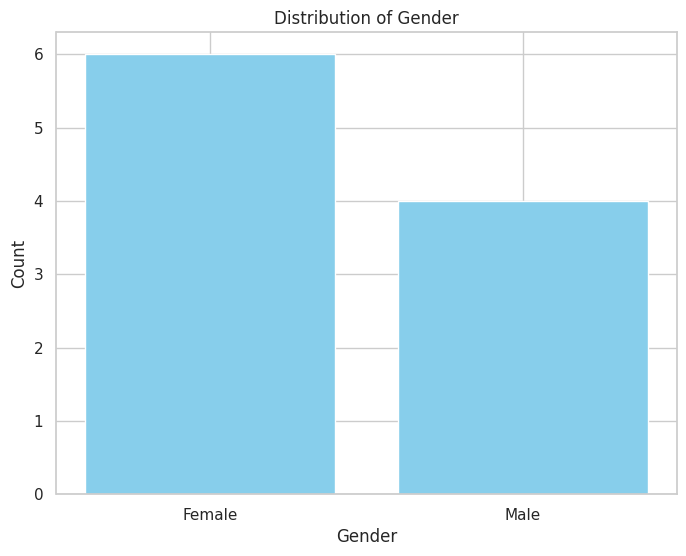

"{'data':    customerID  gender  SeniorCitizen Partner Dependents\n0  0003-MKNFE    Male              0      No         No\n1  0004-TLHLJ    Male              0      No         No\n2  0011-IGKFF    Male              1     Yes         No\n3  0013-EXCHZ  Female              1     Yes         No\n4  0013-SMEOE  Female              1     Yes         No\n5  0015-UOCOJ  Female              1      No         No\n6  0017-DINOC    Male              0      No         No\n7  0017-IUDMW  Female              0     Yes        Yes\n8  0019-EFAEP  Female              0      No         No\n9  0019-GFNTW  Female              0      No         No}"

In [267]:
python_inter(code_str)

## 4.2 把可视化图片存入云盘文档

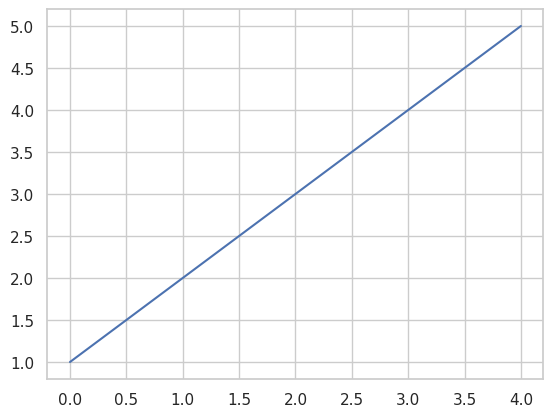

In [268]:
import matplotlib.pyplot as plt

# 创建一个图形
fig, ax = plt.subplots()
ax.plot([1, 2, 3, 4, 5])

In [269]:
type(fig)

matplotlib.figure.Figure

In [30]:
from docx import Document
import matplotlib.pyplot as plt
import os
import tempfile

def append_img_in_doc(folder_name, doc_name, img):
    """"
    往文件里追加图片
    @param folder_name=目录名，doc_name=文件名，img=图片对象，数据类型为matplotlib.figure.Figure对象
    """
    base_path = "/root/autodl-tmp/iquery项目/iquery云盘"
    ## 目录地址
    full_path_folder=base_path+"/"+folder_name
    ## 文件地址
    full_path_doc = os.path.join(full_path_folder, doc_name)+".doc"
    

    # 检查目录是否存在，如果不存在则创建
    if not os.path.exists(full_path_folder):
        os.makedirs(full_path_folder)
    
    # 检查文件是否存在
    if os.path.exists(full_path_doc):
        print(full_path_doc)
        # 文件存在，打开并追加内容
        document = Document(full_path_doc)
    else:
        # 文件不存在，创建一个新的文档对象
        document = Document()

    # 追加图片
    # 将matplotlib的Figure对象保存为临时图片文件
    with tempfile.NamedTemporaryFile(delete=False, suffix='.png') as tmpfile:
        fig.savefig(tmpfile.name, format='png')
        # 将图片插入到.docx文档中
        document.add_picture(tmpfile.name)
    
    # 保存文档
    document.save(full_path_doc)
    print(f"图片已追加到 {doc_name}")

In [271]:
append_img_in_doc(folder_name="电信用户行为分析", doc_name="数据分析问答", img=fig)

/root/autodl-tmp/iquery项目/iquery云盘/电信用户行为分析/数据分析问答.doc
图片已追加到 数据分析问答


# 5. 实现把图片变为fig对象的代码逻辑

In [272]:
messages=[
            {"role": "user", "content": "已经读取iquery数据库中的user_payments数据表，并保存为test_dataframe"},
            {"role": "user", "content": "test_dataframe是已经定义好的变量"},
            {"role": "user", "content": "请帮我统计test_dataframe中gender字段的不同取值分布情况，并以可视化形式进行展示，可视化展示时请尽量绘制更加清晰美观的图片"}
        ]
    
response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        tools=tools,
        tool_choice="auto",  
    )

response.choices[0].message

ChatCompletionMessage(content='', role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_UtO3ktvkVhgMxog7boQfWN5y', function=Function(arguments='{\n  "py_code": "import matplotlib.pyplot as plt\\n\\n# 统计gender字段的不同取值分布情况\\ngender_counts = test_dataframe[\'gender\'].value_counts()\\n\\n# 绘制柱状图\\nplt.figure(figsize=(8, 6))\\nplt.bar(gender_counts.index, gender_counts.values)\\nplt.xlabel(\'Gender\')\\nplt.ylabel(\'Count\')\\nplt.title(\'Distribution of Gender\')\\n\\n# 展示图形\\nplt.show()"\n}', name='python_inter'), type='function')])

In [273]:
code = json.loads(response.choices[0].message.tool_calls[0].function.arguments)
code_str = code.get("py_code")
code_str

"import matplotlib.pyplot as plt\n\n# 统计gender字段的不同取值分布情况\ngender_counts = test_dataframe['gender'].value_counts()\n\n# 绘制柱状图\nplt.figure(figsize=(8, 6))\nplt.bar(gender_counts.index, gender_counts.values)\nplt.xlabel('Gender')\nplt.ylabel('Count')\nplt.title('Distribution of Gender')\n\n# 展示图形\nplt.show()"

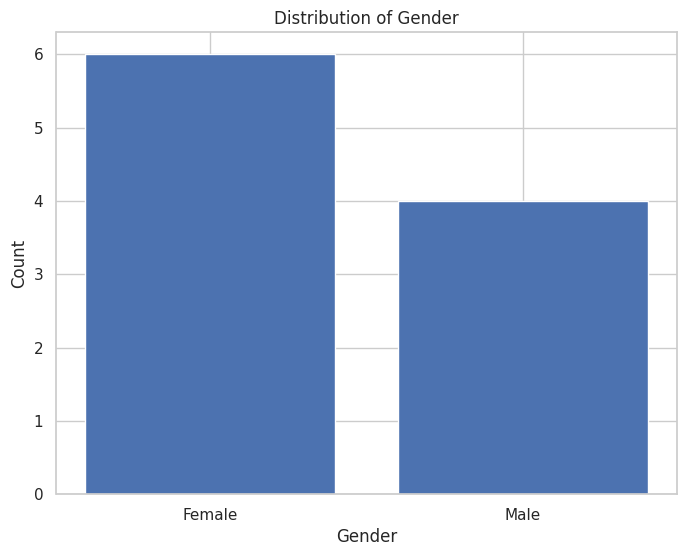

'已经顺利执行代码'

In [274]:
python_inter(code_str)

In [275]:
code_str

"import matplotlib.pyplot as plt\n\n# 统计gender字段的不同取值分布情况\ngender_counts = test_dataframe['gender'].value_counts()\n\n# 绘制柱状图\nplt.figure(figsize=(8, 6))\nplt.bar(gender_counts.index, gender_counts.values)\nplt.xlabel('Gender')\nplt.ylabel('Count')\nplt.title('Distribution of Gender')\n\n# 展示图形\nplt.show()"

In [31]:
def insert_fig_object(code_str):
    global fig
    # 检查是否已存在 fig 对象的创建
    if 'fig = plt.figure' in code_str:
        return code_str  # 如果存在，则返回原始代码字符串

    # 定义可能的库别名和全名
    plot_aliases = ['plt.', 'matplotlib.pyplot.','plot']
    sns_aliases = ['sns.', 'seaborn.']

    # 寻找第一次出现绘图相关代码的位置
    first_plot_occurrence = min((code_str.find(alias) for alias in plot_aliases + sns_aliases if code_str.find(alias) >= 0), default=-1)
 
    # 如果找到绘图代码，则在该位置之前插入 fig 对象的创建
    if first_plot_occurrence != -1:
        plt_figure_index = code_str.find('plt.figure')
        if plt_figure_index != -1:
            # 寻找 plt.figure 后的括号位置，以确定是否有参数
            closing_bracket_index = code_str.find(')', plt_figure_index)
            # 如果找到了 plt.figure()，则替换为 fig = plt.figure()
            modified_str = code_str[:plt_figure_index] + 'fig = ' + code_str[plt_figure_index:closing_bracket_index + 1] + code_str[closing_bracket_index + 1:]
        else:
            modified_str = code_str[:first_plot_occurrence] + 'fig = plt.figure()\n' + code_str[first_plot_occurrence:]
        return modified_str
    else:
        return code_str  # 如果没有找到绘图代码，则返回原始代码字符串

In [158]:
code_temp1=(
 "import matplotlib.pyplot as plt\nimport seaborn as sns\n\ncounts = test_dataframe['gender'].value_counts()\n\nplt.figure(figsize=(8,6))\nsns.set(style='whitegrid')\nsns.barplot(x=counts.index, y=counts.values)\nplt.title('Distribution of Gender in test_dataframe')\nplt.xlabel('Gender')\nplt.ylabel('Count')\nplt.show()"
)
modified_str = insert_fig_object(code_temp1)
print(modified_str)

import matplotlib.pyplot as plt
import seaborn as sns

counts = test_dataframe['gender'].value_counts()

fig = plt.figure(figsize=(8,6))
sns.set(style='whitegrid')
sns.barplot(x=counts.index, y=counts.values)
plt.title('Distribution of Gender in test_dataframe')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


In [277]:
code_temp1=(
"import matplotlib.pyplot as plt\n\n# 统计gender字段的不同取值分布情况\ngender_counts = test_dataframe['gender'].value_counts()\n\n# 绘制柱状图\nplt.figure(figsize=(8, 6))\nplt.bar(gender_counts.index, gender_counts.values)\nplt.xlabel('Gender')\nplt.ylabel('Count')\nplt.title('Distribution of Gender')\n\n# 展示图形\nplt.show()"
)
modified_str = insert_fig_object(code_temp1)
print(modified_str)

import matplotlib.pyplot as plt

# 统计gender字段的不同取值分布情况
gender_counts = test_dataframe['gender'].value_counts()

# 绘制柱状图
fig = plt.figure(figsize=(8, 6))
plt.bar(gender_counts.index, gender_counts.values)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Distribution of Gender')

# 展示图形
plt.show()


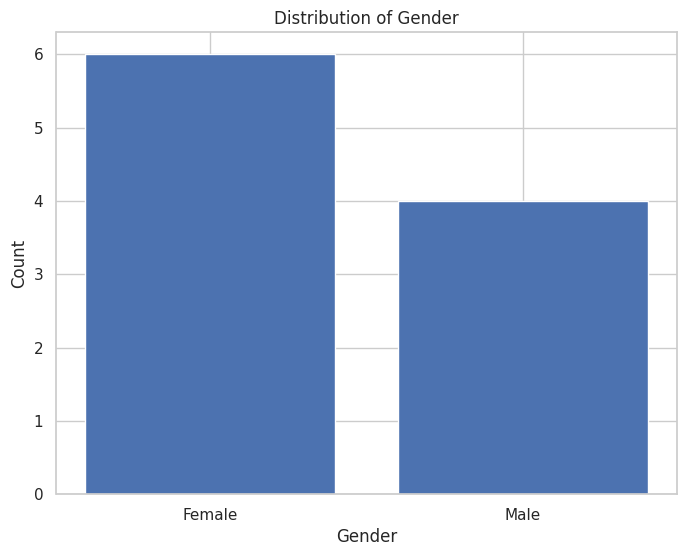

In [278]:
import matplotlib.pyplot as plt

# 统计gender字段的不同取值分布情况
gender_counts = test_dataframe['gender'].value_counts()

# 绘制柱状图
fig = plt.figure(figsize=(8, 6))
plt.bar(gender_counts.index, gender_counts.values)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Distribution of Gender')

# 展示图形
plt.show()

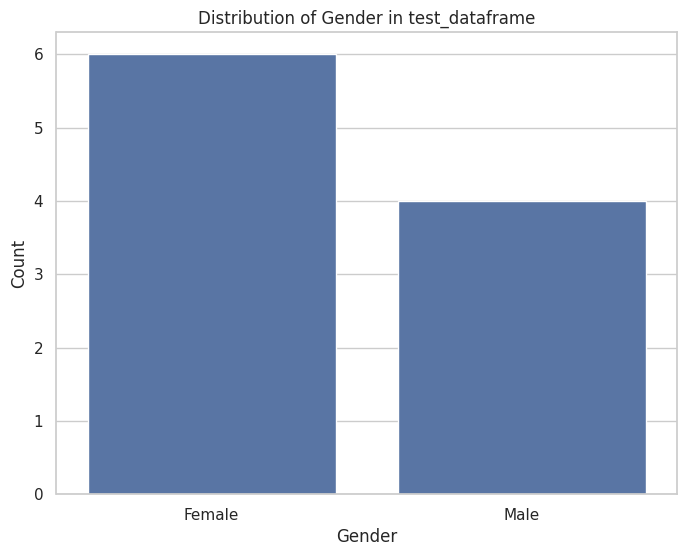

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns

counts = test_dataframe['gender'].value_counts()

fig = plt.figure(figsize=(8,6))
sns.set(style='whitegrid')
sns.barplot(x=counts.index, y=counts.values)
plt.title('Distribution of Gender in test_dataframe')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

In [32]:
def extract_python(json_str):
       # 使用literal_eval将字符串转换为字典
    dict_data = json.loads(json_str)
    # 提取'sql_query'的值
    py_code_value = dict_data['py_code']
    # 提取并返回'sql_query'的值
    return py_code_value

In [280]:
json_str = response.choices[0].message.tool_calls[0].function.arguments
print(json_str)
print(extract_python(json_str))

{
  "py_code": "import matplotlib.pyplot as plt\n\n# 统计gender字段的不同取值分布情况\ngender_counts = test_dataframe['gender'].value_counts()\n\n# 绘制柱状图\nplt.figure(figsize=(8, 6))\nplt.bar(gender_counts.index, gender_counts.values)\nplt.xlabel('Gender')\nplt.ylabel('Count')\nplt.title('Distribution of Gender')\n\n# 展示图形\nplt.show()"
}
import matplotlib.pyplot as plt

# 统计gender字段的不同取值分布情况
gender_counts = test_dataframe['gender'].value_counts()

# 绘制柱状图
plt.figure(figsize=(8, 6))
plt.bar(gender_counts.index, gender_counts.values)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Distribution of Gender')

# 展示图形
plt.show()


In [33]:
def python_inter(py_code):
    """
    用于对chatbi数据库中各张数据表进行查询和处理，并获取最终查询或处理结果。
    :param py_code: 字符串形式的Python代码，用于执行对chatbi数据库中各张数据表进行操作
    :return：代码运行的最终结果
    """    
    # 添加图片对象，如果存在绘图代码，则创建fig对象
    py_code = insert_fig_object(py_code)
    global_vars_before = set(globals().keys())
    try:
        exec(py_code, globals())
    except Exception as e:
        return str(e)
    global_vars_after = set(globals().keys())
    new_vars = global_vars_after - global_vars_before
    if new_vars:
        result = {var: globals()[var] for var in new_vars}
        return str(result)
    else:
        try:
            return str(eval(py_code, globals()))
        except Exception as e:
            return "已经顺利执行代码"

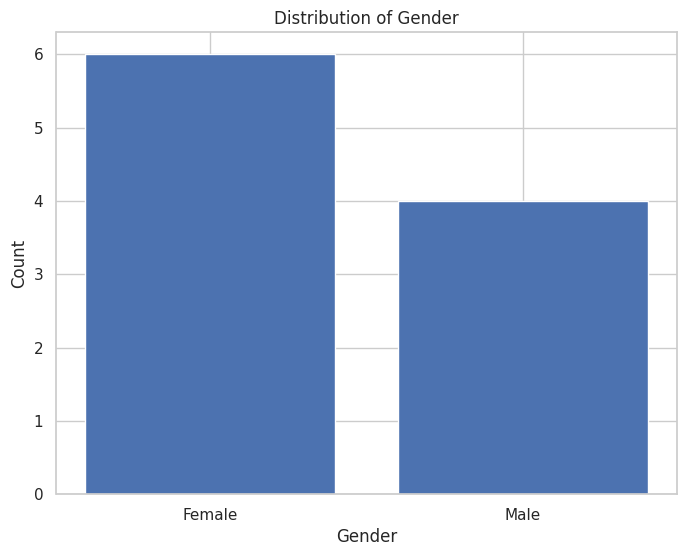

'已经顺利执行代码'

In [282]:
python_inter(code_str)

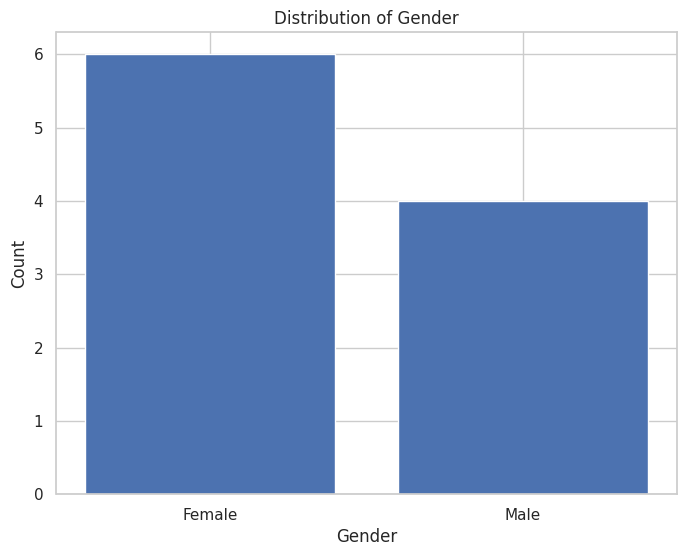

In [283]:
fig

# 6. 多轮对话增加Python代码解释器效果

In [80]:
def extract_python(json_str):
    if isinstance(json_str, dict):
        return json_str['py_code']   
       # 使用literal_eval将字符串转换为字典
    dict_data = json.loads(json_str)
    # 提取'sql_query'的值
    py_code_value = dict_data['py_code']
    # 提取并返回'sql_query'的值
    return py_code_value

In [62]:
def check_code_run(messages,
                   project_name,
                   doc_name,
                   functions_list=None,
                   tools=None,
                   model="gpt-3.5-turbo",
                   auto_run = True):
    """
    能够自动执行外部函数调用的对话模型
    :param messages: 必要参数，字典类型，输入到Chat模型的messages参数对象
    :param prject_name: 项目名
    :param doc_name: 文件名
    :param functions_list: 可选参数，默认为None，可以设置为包含全部外部函数的列表对象
    :param model: Chat模型，可选参数，默认模型为gpt-3.5-turbo
    :return：Chat模型输出结果
    """
    code = None
    # 如果没有外部函数库，则执行普通的对话任务
    if functions_list == None:
        response = client.chat.completions.create(
                        model=model,
                        messages=messages,
                        )
        response_message = response.choices[0].message
        final_response = response_message.content
        
    # 若存在外部函数库，则需要灵活选取外部函数并进行回答
    else:

        # 创建外部函数库字典
        available_functions = {func.__name__: func for func in functions_list}

        # 第一次调用大模型
        response = client.chat.completions.create(
                        model=model,
                        messages=messages,
                        tools=tools,
                        tool_choice="auto", )
        response_message = response.choices[0].message
        tool_calls = response_message.tool_calls
        if tool_calls:
            messages.append(response_message) 
            for tool_call in tool_calls:
                function_name = tool_call.function.name
                function_to_call = available_functions[function_name]
                function_args = json.loads(tool_call.function.arguments)
                #########################################
                    # 创建code对象
                if 'sql_inter' in function_name or 'extract_data' in function_name:
                    code = extract_sql(function_args)
                    # 将代码字符串转换为Markdown格式
                    markdown_code = f"```sql\n{code}\n```"
                else:
                    code = extract_python(function_args)
                    
                    code = insert_fig_object(code)
                    # 将代码字符串转换为Markdown格式
                    markdown_code = f"```python\n{code}\n```"
                #########################################
              
                if auto_run == False: 
                    print("已将问题转化为如下代码准备运行：")
                    # 在Jupyter Notebook中展示Markdown格式的代码
                    display(Markdown(markdown_code))
                    #sql_query = extract_sql_by_str(function_args)
                    #print("抽取出来的SQL：" + sql_query)

                    res = input('是否确认并继续执行（1），或者退出本次运行过程（2）')
                    if res == '2':
                        print("终止运行")
                        return None
                    else:
                        print("正在执行代码，请稍后...")
                        
                function_response = function_to_call(**function_args)
                messages.append(
                    {
                        "tool_call_id": tool_call.id,
                        "role": "tool",
                        "name": function_name,
                        "content": function_response,
                    }
                ) 
            ## 第二次调用模型
            second_response = client.chat.completions.create(
                model=model,
                messages=messages,
            ) 
            # 获取最终结果
            final_response = second_response.choices[0].message.content
        else:
            final_response = response_message.content
    del messages
    ##################################
    if code:
        substrings = ['plt.', 'matplotlib.pyplot.', 'sns.', 'seaborn.','plot']
        if any(substring in code for substring in substrings):
            global fig
            append_img_in_doc(project_name, doc_name, img=fig)
            print("图片保存成功！")
    ################################
                
    return final_response

In [70]:
import tiktoken

def chat_with_inter(functions_list=None, 
                    prompt="你好呀", 
                    model="gpt-3.5-turbo", 
                    system_message=[{"role": "system", "content": "你是一个智能助手。"}], 
                    auto_run = True):
    
    print("正在初始化外部函数库")
    # 创建函数列表对应的参数解释列表
    functions = auto_functions(functions_list)
    #print(functions)
    print("外部函数库初始化完成")
    project_name = input("请输入当前分析项目名称：")
    folder_name = create_directory(project_name)
    print("已完成数据分析文件创建")
    doc_name = input("请输入当前分析阶段，如数据探索阶段和理解、数据清洗阶段等：")
    doc_name += '问答'
    print("好的，即将进入交互式分析流程")
    # 多轮对话阈值
    if 'gpt-4' in model:
        tokens_thr = 6000
    elif '16k' in model:
        tokens_thr = 14000
    else:
        tokens_thr = 3000
    
    messages = system_message
    ## 完成给用户输入的问题赋值
    user_input = prompt
    messages.append({"role": "user", "content": prompt})
    ## 计算token大小
    embedding_model = "text-embedding-ada-002"
    # 模型对应的分词器（TOKENIZER）
    embedding_encoding = "cl100k_base"
    encoding = tiktoken.get_encoding(embedding_encoding)
    tokens_count = len(encoding.encode((prompt + system_message[0]["content"])))
    
    while True:           
        answer = check_code_run(messages,
                                project_name=project_name,
                                doc_name = doc_name,
                                functions_list=functions_list, 
                                tools=functions,
                                model=model, 
                                auto_run = auto_run)
        
        
        print(f"模型回答: {answer}")
        
        #####################判断是否记录文档 start#######################
        while True:
            record = input('是否记录本次回答（1），还是再次输入问题并生成该问题答案（2）')
            if record == '1':
                
                Q_temp = 'Q:' + user_input
                A_temp = 'A:' + answer
                
                append_in_doc(folder_name=project_name, 
                                               doc_name=doc_name, 
                                               qa_string=Q_temp)
                append_in_doc(folder_name=project_name, 
                                               doc_name=doc_name, 
                                               qa_string=A_temp)
                
                # 记录本轮问题答案
                messages.append({"role": "assistant", "content": answer})
                break
            else:
                print('好的，请再次输入问题')
                user_input = input()
                messages[-1]["content"] = user_input
                answer = check_code_run(messages, 
                                        project_name=project_name,
                                        doc_name = doc_name,
                                        functions_list=functions_list,
                                        tools=functions,
                                        model=model,                                       
                                        auto_run = auto_run)  
                
                print(f"模型回答: {answer}")
                
        ########################判断是否记录文档 stop #######################
        

        # 询问用户是否还有其他问题
        user_input = input("您还有其他问题吗？(输入退出以结束对话): ")
        if user_input == "退出":
            del messages
            break

        # 记录新一轮问答
        messages.append({"role": "assistant", "content": answer})
        messages.append({"role": "user", "content": user_input})
        
        # 计算当前总token数
        tokens_count += len(encoding.encode((answer + user_input)))
        
        # 删除超出token阈值的对话内容
        while tokens_count >= tokens_thr:
            tokens_count -= len(encoding.encode(messages.pop(1)["content"]))

In [64]:
#sql_inter,
functions_list = [extract_data, python_inter]

In [65]:
from IPython.display import display, Markdown, Code

正在初始化外部函数库
[{'type': 'function', 'function': {'name': 'extract_data', 'description': '用于借助pymysql，将MySQL中的iquery数据库中的表读取并保存到本地Python环境中。', 'parameters': {'type': 'object', 'properties': {'sql_query': {'type': 'string', 'description': '字符串形式的SQL查询语句，用于提取MySQL中iquery数据库中的某张表。'}, 'df_name': {'type': 'string', 'description': '将MySQL数据库中提取的表格进行本地保存时的变量名，以字符串形式表示。'}}, 'required': ['sql_query', 'df_name']}}}, {'type': 'function', 'function': {'name': 'python_inter', 'description': '用于对chatbi数据库中各张数据表进行查询和处理，并获取最终查询或处理结果。', 'parameters': {'type': 'object', 'properties': {'py_code': {'type': 'string', 'description': '字符串形式的Python代码，用于执行对chatbi数据库中各张数据表进行操作'}}, 'required': ['py_code']}}}]
外部函数库初始化完成


请输入当前分析项目名称： 电信用户行为分析


目录 电信用户行为分析 已存在
已完成数据分析文件创建


请输入当前分析阶段，如数据探索阶段和理解、数据清洗阶段等： 数据可视化


好的，即将进入交互式分析流程
已将问题转化为如下代码准备运行：


```sql
SELECT * FROM user_demographics
```

是否确认并继续执行（1），或者退出本次运行过程（2） 1


正在执行代码，请稍后...


/tmp/ipykernel_150812/966933623.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  globals()[df_name] = pd.read_sql(sql_query, connection)


模型回答: 已将iquery数据库中的user_demographics数据表保存到本地Python环境中，并命名为user_demographics_df。您可以使用该变量进行进一步的数据分析和处理了。


是否记录本次回答（1），还是再次输入问题并生成该问题答案（2） 1


内容已追加到 数据可视化问答
内容已追加到 数据可视化问答


您还有其他问题吗？(输入退出以结束对话):  用可视化的方式展示user_demographics_df数据集中gender字段不同取值的占比情况


已将问题转化为如下代码准备运行：


```python
import matplotlib.pyplot as plt

# 计算gender字段不同取值的占比
gender_counts = user_demographics_df['gender'].value_counts()

# 绘制饼图
fig = plt.figure(figsize=(6,6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Gender Distribution')
plt.show()
```

是否确认并继续执行（1），或者退出本次运行过程（2） 1


正在执行代码，请稍后...


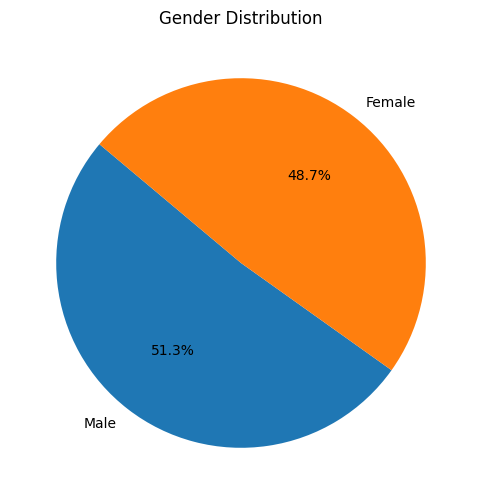

/root/autodl-tmp/iquery项目/iquery云盘/电信用户行为分析/数据可视化问答.doc
图片已追加到 数据可视化问答
图片保存成功！
模型回答: 


是否记录本次回答（1），还是再次输入问题并生成该问题答案（2） 解释一下user_demographics_df数据集字段


好的，请再次输入问题


 user_demographics_df数据集字段


已将问题转化为如下代码准备运行：


```python
import pandas as pd
import matplotlib.pyplot as plt

# 将数据集转换为DataFrame
user_demographics_df = pd.DataFrame(user_demographics_df)

# 统计gender字段不同取值的数量
gender_counts = user_demographics_df['gender'].value_counts()

# 绘制饼图
fig = plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Gender Distribution')
plt.axis('equal')
plt.show()
```

是否确认并继续执行（1），或者退出本次运行过程（2） 1


正在执行代码，请稍后...


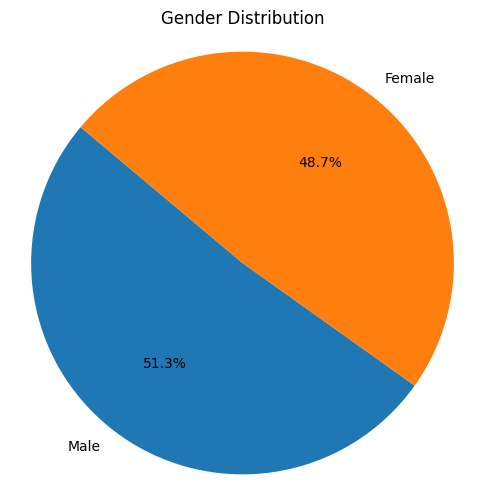

/root/autodl-tmp/iquery项目/iquery云盘/电信用户行为分析/数据可视化问答.doc
图片已追加到 数据可视化问答
图片保存成功！
模型回答: 以下是user_demographics_df数据集中gender字段不同取值的占比情况的可视化结果：


是否记录本次回答（1），还是再次输入问题并生成该问题答案（2） 1


内容已追加到 数据可视化问答
内容已追加到 数据可视化问答


您还有其他问题吗？(输入退出以结束对话):  退出


In [86]:
chat_with_inter(functions_list=functions_list, 
                prompt="请将iquery数据库中的user_demographics表保存到本地Python环境中，并命名为user_demographics_df", 
                model="gpt-3.5-turbo", 
                system_message=[{"role": "system", "content": md_content}], 
                auto_run = False)
## 用可视化的方式展示user_demographics_df数据集中gender字段不同取值的占比情况